In [1]:
import sys
import os.path
from sys import argv, exit
# Using the MathJax library to display the Latex.
from IPython.display import Math
#
import numpy as np
import pandas as pd
import os
os.chdir("/home/jobel/gits/jobel")

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib import artist
from matplotlib import rc, rcParams

rc('mathtext', default='regular')
rc('font', family='sans-serif') 
rc('font', serif='Arial') 
#rc('text', usetex='false') 
rcParams.update({'font.size': 22})
%matplotlib inline


In [3]:
# Better colormap
import pickle
dirname = "/home/jobel/Dropbox/Manuscripts_EOData2015/Manuscript_IV/colormap"
filename = "matplotlib_option_D.pickle"
with open(os.path.join(dirname,filename),"rb") as handle:
    cmap_D =  pickle.load(handle)
plt.register_cmap(cmap=cmap_D)

In [4]:
import xray

In [5]:
try:
    curonian =  xray.open_dataset("/media/jobel/SeagateDrive/diana_meris/sub_subset_MER_FRS_2PPDSI20100721_reprojected_UTMWGS84.nc")  #"/media/jobel/SeagateDrive/diana_meris/subset_MERIS_20100721_090501.nc")
except:
    print "curonian failed"
try:
    himmer =  xray.open_dataset("/media/jobel/work/testing/elinas_selection/collocated_UTM33_WGS84_MER_FSG_2PNMAP20080731_093356_000000392070_00437_33557_0001.nc") #("/media/jobel/work/testing/elinas_selection/collocated_UTM33_WGS84_MER_FRG_2PNMAP20100703_101033_000000452090_00466_43606_0001.nc")
except:
    print "himmer failed"

#curonian.keys(), himmer.keys()

In [6]:
@np.vectorize
def turbidity_kari(spm):
    #  t = exp(1.031*ln(SPM)+0.084) 
    # According with in situ data Kari et al.    
    return   np.exp(1.031*np.log(spm)+0.084)

In [7]:
#
# cl --> Curonian Lagoon 
# hf --->Himmerfjärden
#
turbidity = {"cl":[],"hf":[]} 
turbidity["hf"] = turbidity_kari(np.ma.masked_invalid(himmer.suspended_particle_matter))
turbidity["cl"] = turbidity_kari(np.ma.masked_invalid(curonian.total_susp))

In [8]:
from mpl_toolkits.basemap import Basemap
# Use the following to get a georeferenced map with a shapefile for coastlines
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
#
lon_0, lat_0,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat = {},{},{},{},{},{}

In [9]:
# cl --> Curonian Lagoon 
lon_0["cl"]=19.985708
lat_0["cl"]=55.472336
llcrnrlon["cl"]=17.55
llcrnrlat["cl"]= 53.82
urcrnrlon["cl"]=23.0
urcrnrlat["cl"]=56.90
# hf --->Himmerfjärden
lon_0["hf"]=17.716677
lat_0["hf"]=59.0
llcrnrlon["hf"]=17.4336149528
llcrnrlat["hf"]=58.6214157187
urcrnrlon["hf"]=18.235
urcrnrlat["hf"]=59.1725424757

In [10]:
ax = {}
data = {}
im = {}
basemap = {}
cmap = {}
divider = {}
datestring = {"hf":"2008-07-31", "cl":"2010-07-21"}#"2011-07-03"
scale ={"cl":{"lat":54,"lon":21.4,"length":100},"hf":{"lat":58.64,"lon":18.05, "length":10}}

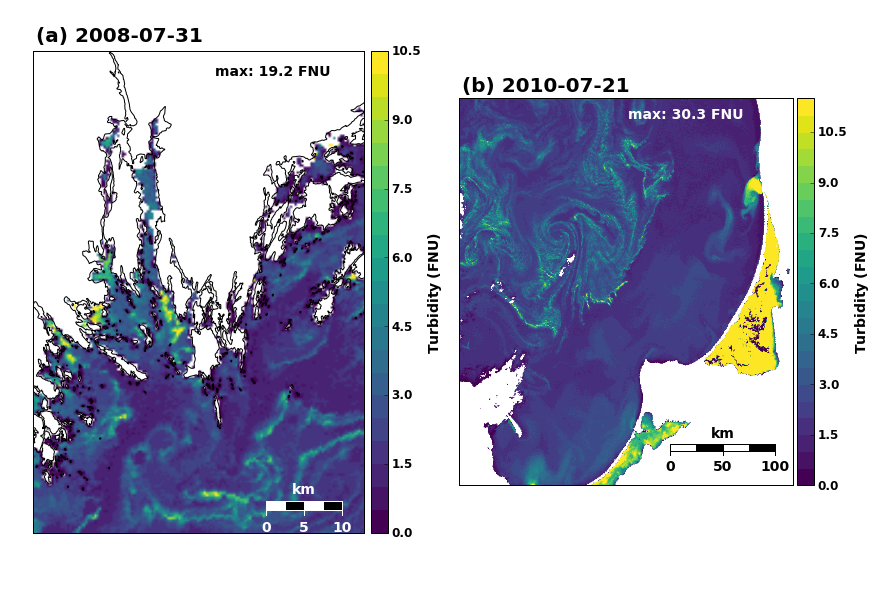

In [20]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'serif':'Arial',
        'size'   : 12} # 
rc('font', **font)
rc('xtick', labelsize=12) 
rc('ytick', labelsize=12) 

# ## Used for dual l2p plotting
#########################
my_dpi = 600 #(3719, 2519)
fig = plt.figure(figsize=(14,10), dpi=600)  #figsize=(1008/my_dpi, 1450/my_dpi), dpi=my_dpi)
ax["fig"] = plt.gca()
ax["fig"].axis('off')
fig.patch.set_facecolor('white')
#plt.suptitle("MEGS DATE: " + date_string[:4] + "-" + date_string[4:6] + "-" + date_string[6:8])
# current region of interest (ROI)
ROI = "hf"
ax[ROI] = fig.add_subplot(1, 2, 1)
ax[ROI].xaxis.set_visible(False)
ax[ROI].yaxis.set_visible(False)
#
data[ROI] = turbidity[ROI]
data[ROI] = np.fliplr(np.rot90(data[ROI],2))
im[ROI] = plt.imshow(data[ROI])

################################
basemap[ROI] = Basemap(projection='tmerc',lon_0=lon_0[ROI],lat_0=lat_0[ROI],
            k_0=0.9996, epsg=5650,
            llcrnrlon=llcrnrlon[ROI],llcrnrlat=llcrnrlat[ROI],urcrnrlon=urcrnrlon[ROI],urcrnrlat=urcrnrlat[ROI],
            resolution='i', ax=ax[ROI] )

basemap[ROI].drawmapboundary(fill_color='white')
# Reading the shapefile
basemap[ROI].readshapefile('/home/jobel/Dropbox/GIS_repository/Himmer_LatLon', 'himmer', drawbounds = False) # 
patches   = []

for info, shape in zip(basemap[ROI].himmer_info, basemap[ROI].himmer):
    #if info['nombre'] == 'Selva':
    patches.append( Polygon(np.array(shape), True) )
        
ax[ROI].add_collection(PatchCollection(patches, facecolor= 'none', edgecolor='k', linewidths=1., zorder=2))


basemap[ROI].drawmapscale(ax=ax[ROI],lon=scale[ROI]["lon"], lat=scale[ROI]["lat"],
               lon0=lon_0[ROI], lat0=lat_0[ROI], length=scale[ROI]["length"], fontsize=14,
               barstyle='fancy',units='km', labelstyle='simple', fontcolor='white')
#############
#
# Discrete colours 
cmap[ROI] = cmap_D
# extract all colors from the colourmap
cmaplist = [cmap[ROI](i) for i in range(cmap[ROI].N)]
# Adjusting the last colour to darker red
#cmaplist[-1] = '#990000'
# create the new map
cmap[ROI] = cmap[ROI].from_list('Custom cmap', cmaplist, cmap[ROI].N)
# define the bins and normalize
bounds = np.arange(0, 10 + 1, 0.5) 
norm = colors.BoundaryNorm(bounds, cmap[ROI].N)
# Setting the masked values to white
cmap[ROI].set_bad("w",1.0)
im[ROI].set_cmap(cmap[ROI])
im[ROI].set_norm(norm)
################################################################
basemap[ROI].imshow(data[ROI], cmap = cmap[ROI], norm=norm)
################################################################
ax[ROI].set_axis_bgcolor('grey')


divider[ROI] = make_axes_locatable(ax[ROI])
cax = divider[ROI].append_axes("right", size = "5%", pad = 0.1)
cbar = plt.colorbar(im[ROI], cax = cax)  #use_gridspec=True
im[ROI].set_clim(0, 11) # (0,14)
cbar.set_label("$Turbidity\;(FNU)$", size=14, weight = 'bold')
ax[ROI].text(0.01, 1.02, "(a) "+datestring[ROI],
        horizontalalignment='left',
        fontsize=20,
        transform = ax[ROI].transAxes, color = "black")
ax[ROI].text(0.9, 0.95, "max: "+"%.1f"% np.ma.max(data[ROI])+" FNU",
        horizontalalignment='right',
        fontsize=14,
        transform = ax[ROI].transAxes, color = "black")

#cbar.remove()
##################################################################################################

ROI = "cl"
ax[ROI] = fig.add_subplot(1, 2, 2)
ax[ROI].xaxis.set_visible(False)
ax[ROI].yaxis.set_visible(False)
#
data[ROI] = turbidity[ROI]
data[ROI] = np.fliplr(np.rot90(data[ROI],2))
im[ROI] = plt.imshow(data[ROI])

################################
basemap[ROI] = Basemap(projection='tmerc',lon_0=lon_0[ROI],lat_0=lat_0[ROI],
            k_0=0.9996, epsg=5650,
            llcrnrlon=llcrnrlon[ROI],llcrnrlat=llcrnrlat[ROI],urcrnrlon=urcrnrlon[ROI],urcrnrlat=urcrnrlat[ROI],
            resolution='i', ax=ax[ROI] )
basemap[ROI].drawmapscale(ax=ax[ROI],lon=scale[ROI]["lon"], lat=scale[ROI]["lat"],
               lon0=lon_0[ROI], lat0=lat_0[ROI], length=scale[ROI]["length"], fontsize=14,
               barstyle='fancy',units='km', labelstyle='simple', fontcolor='black')
#############
#
# Discrete colours 
cmap[ROI] = cmap_D
# extract all colors from the colourmap
cmaplist = [cmap[ROI](i) for i in range(cmap[ROI].N)]
# Adjusting the last colour to darker red
#cmaplist[-1] = '#990000'
# create the new map
cmap[ROI] = cmap[ROI].from_list('Custom cmap', cmaplist, cmap[ROI].N)
# define the bins and normalize
bounds = np.arange(0, 11 + 1, 0.5) 
norm = colors.BoundaryNorm(bounds, cmap[ROI].N)
# Setting the masked values to white
cmap[ROI].set_bad("w",1.0)
im[ROI].set_cmap(cmap[ROI])
im[ROI].set_norm(norm)
################################################################
basemap[ROI].imshow(data[ROI], cmap = cmap[ROI], norm=norm)
################################################################
ax[ROI].set_axis_bgcolor('grey')


divider[ROI] = make_axes_locatable(ax[ROI])
cax = divider[ROI].append_axes("right", size = "5%", pad = 0.05)
cbar = plt.colorbar(im[ROI], cax = cax)  #use_gridspec=True
im[ROI].set_clim(0, 12) # (0,14)
cbar.set_label("$Turbidity\;(FNU)$", size=14, weight = 'bold')

ax[ROI].text(0.01, 1.02, "(b) "+ datestring[ROI],
        horizontalalignment='left',
        fontsize=20,
        transform = ax[ROI].transAxes, color = "black")

ax[ROI].text(0.85, 0.95, "max: "+"%.1f"% np.ma.max(data[ROI])+" FNU",
        horizontalalignment='right',
        fontsize=14,
        transform = ax[ROI].transAxes, color = "white", weight = 'bold')

plt.subplots_adjust()  # top = 0.85, left = 0.15, right = 0.85
## pad=0 clips some of the texts by a few pixels.
## This may be a bug or a limitation of the current algorithm and it is not clear why it happens.
## Meanwhile, use of pad at least larger than 0.3 is recommended.
#plt.tight_layout(pad = 0.5)
#plt.show()

#cbar.remove()
##################################################################################################